# Import libs and data extracting

In [ ]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

In [ ]:
!unzip -q data_science_task.zip -d /content

In [ ]:
# check out what we've unzipped
!ls /content

df_test.csv  df_train.csv  drive  sample_data


In [ ]:
train_df = pd.read_csv('/content/df_train.csv')
test_df = pd.read_csv('/content/df_test.csv')

train_df.head()

,Unnamed: 0,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,item_type,client_keywords,client_device_type,client_browser,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses
0,0,1c25f312-fefc-41ee-b328-8fe1fd188e75,12,565.0,466,12,162.0,888,2017-12-27 09:49:55,00-48-00 2018-01-02,12-04-00 2018-01-03,18-09-00 2018-01-03,0,"[326, 51, 37]",1,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],b1905241-ab8b-40e6-ae0a-8f614656f304,25f9f297-40a8-45d9-bb67-4b0f6dad1315,409f1e13-81ae-4e36-9bd2-6a6c53d38601,1,443.228241,0.000000
1,1,c2a596a4-1a51-4269-b9f0-5c943c4f830d,12,361.0,292,12,121.0,351,2016-10-17 21:17:17,14-50-00 2016-11-02,21-33-00 2016-11-02,08-10-00 2016-11-03,0,[77],2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['9e20fbd2-b0aa-4b6a-ae04-0fb3724f5a5d', '73d1...",5121ddf1-2a2b-4cff-a1db-7b8550799cd6,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,589.481978,0.000000
2,2,d84abb0b-29f3-47bd-886e-c7cd3866bc7a,12,125.0,1666,12,634.0,530,2017-04-26 18:23:43,21-15-00 2017-05-06,21-15-00 2017-05-06,00-37-00 2017-05-07,0,None,3,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['3816a29d-7d91-472b-a8b9-7367327800ed', 'af1b...",3bba1740-10f2-47e9-81c4-a75ec9b4445a,5554bea4-f3cd-4432-bb13-73698f52de88,5c8a6701-853f-4721-86f0-86e79f7220c4,2,110.946960,0.000000
3,3,5813b65b-1c55-4faf-83c8-4c1815498f49,12,507.0,263,12,171.0,1398,2017-07-01 20:02:55,20-43-00 2017-07-09,20-43-00 2017-07-09,10-57-00 2017-07-10,0,None,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],0e602b6a-c66c-4e8a-993f-3cea1e4083cc,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,793.902828,0.000000
4,4,7907105b-fe87-412e-996c-bc1a27ae6c94,12,261.0,1597,12,125.0,1666,2017-05-31 18:18:31,21-38-00 2017-06-24,03-42-00 2017-06-25,09-13-00 2017-06-26,0,None,3,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,"['e0cd40f3-e4c4-4040-9a38-d69b5a2dc499', '9e89...",b5f83091-9e74-4b26-a86b-46f524e39489,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,5c8a6701-853f-4721-86f0-86e79f7220c4,2,1174.806858,119.655797


In [ ]:
print('Train size', train_df.shape)
print('Test size', test_df.shape)

# EDA

In [ ]:
# check out the case which train and test data could have mutual samples
set(train_df.order_id)&set(set(test_df.order_id))

set()

In [ ]:
# any missing values?
train_df.isnull().sum()

Unnamed: 0                            0
order_id                              0
departure_country                     0
departure_city                     6320
departure_region                      0
arrival_country                       0
arrival_city                       8863
arrival_region                        0
order_date                            0
stock_departure_date                  0
delivery_service_departure_date       0
client_arrival_date                   0
item_type                             0
client_keywords                       0
client_device_type                    0
client_browser                        0
item_package_type                     0
client_is_app                         0
order_tracking_available              0
brand_name                            0
item_id                               0
item_category                         0
delivery_service_name                 0
type_prepayment                       0
item_price                            0


In [ ]:
# check out data types
train_df.dtypes

Unnamed: 0                           int64
order_id                            object
departure_country                    int64
departure_city                     float64
departure_region                     int64
arrival_country                      int64
arrival_city                       float64
arrival_region                       int64
order_date                          object
stock_departure_date                object
delivery_service_departure_date     object
client_arrival_date                 object
item_type                            int64
client_keywords                     object
client_device_type                   int64
client_browser                       int64
item_package_type                   object
client_is_app                         bool
order_tracking_available             int64
brand_name                          object
item_id                             object
item_category                       object
delivery_service_name               object
type_prepay

I've found some categorical features as int type. It needs to convert to object type.

In [ ]:
int_columns = list(train_df.dtypes[train_df.dtypes == int].index[1:])
train_df[int_columns] = train_df[int_columns].astype(str)

Checking out outliers and distibution.

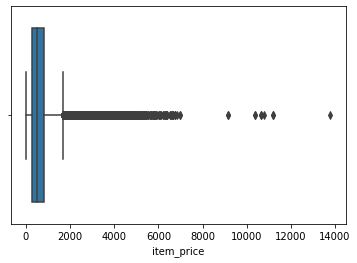

In [ ]:
sns.boxplot(x='item_price', data=train_df);

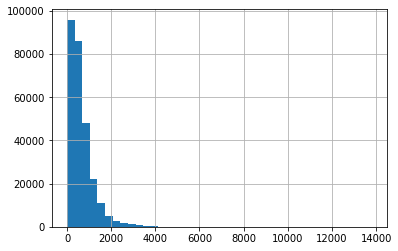

In [ ]:
train_df.item_price.hist(bins=40);

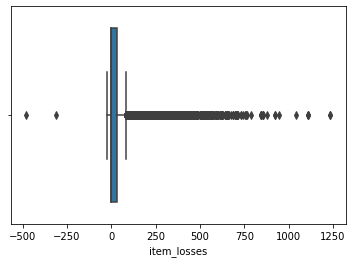

In [ ]:
sns.boxplot(x='item_losses', data=train_df);

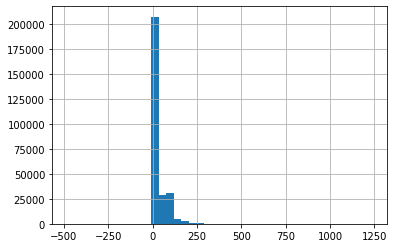

In [ ]:
train_df.item_losses.hist(bins=40);

It seems like a lot of outliers. At least distribution is normal.

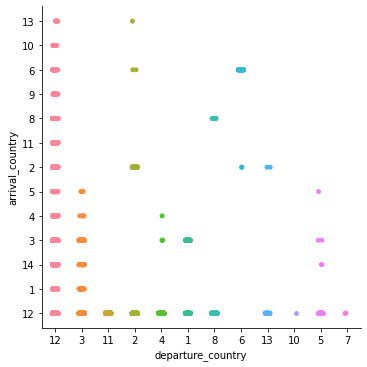

In [ ]:
sns.catplot(x='departure_country', y='arrival_country', data=train_df);

As we can see major part of delivery was international.

In [ ]:
train_df.client_device_type.value_counts()

2       175578
1        42928
0        40824
3        14395
80          75
         ...  
25           1
13           1
1072         1
752          1
761          1
Name: client_device_type, Length: 468, dtype: int64

In [ ]:
train_df.client_browser.value_counts()

1    114417
0     92038
6     24470
3     15906
2     13577
4      8630
5      7166
9         1
Name: client_browser, dtype: int64

In [ ]:
train_df.item_package_type.value_counts()

c82a2ea6-cbf1-46af-98c5-acd43b174f5d    219717
4b30b1ff-54b0-4aac-ac8a-6df7bb59548e     25584
43c32a76-e5a3-4874-85c3-5377fa50b515     17374
7b0818f4-617e-4843-a5c1-634d2c2a3c2f     12937
1d030b8e-b455-4e27-9d19-c68c1d7924a4       593
Name: item_package_type, dtype: int64

In [ ]:
train_df.item_category.value_counts()

ea77a36e-4b0c-4e8d-bf09-4c8398609ae1    99250
25f9f297-40a8-45d9-bb67-4b0f6dad1315    80465
5554bea4-f3cd-4432-bb13-73698f52de88    79302
60959c0c-9c1a-434b-8442-3b8c2fc73655    14463
243f0bd2-7e7b-4b32-96f9-5bd080948936     1636
38541b4d-f0d3-4471-abbc-574f4f1779c8     1089
Name: item_category, dtype: int64

In [ ]:
train_df.delivery_service_name.value_counts()

5c8a6701-853f-4721-86f0-86e79f7220c4    207745
eec00286-b56b-44b0-8882-7b7022355a8f     33555
409f1e13-81ae-4e36-9bd2-6a6c53d38601     11791
3f1e3d6a-a194-4cf9-9026-bb03a8f544c2      6048
85282487-c17a-41ff-bedd-d0461a3e7330      5718
fcaa3980-7779-4590-9c18-8ce1c03b6ee9      5052
bcf8f840-043b-4637-a283-16e561d6a86c      1972
56ecf0d7-73dd-4fee-80c3-9165a889088d      1120
202230b2-235b-4dda-ad57-3a722d4cce5b       973
42f718fe-d3b9-40e6-b5c7-e1cb31e7a7b5       853
12fbc04a-c648-492c-9493-e21a792f228e       475
b56d0da5-84b6-457a-9594-fdd0cd2cae13       266
99e0a8dc-c1f1-4b62-bbd8-e429dbb18c31       209
8742ac10-bec1-4d59-8514-604173977b8d       178
831e66de-a6e9-4cff-b411-8c644b15e8a0       102
a3fbdc94-4e7f-4d9e-bce6-33836a18e294        63
6aa940a0-5d1a-4b33-8346-6a5c8c9d8af4        52
bf42578f-62fd-4022-bb3d-ade42eb27b1e         9
1b24a233-92c5-486a-acce-a337ff14fa21         6
5b3f20f0-d81d-4abe-add6-cbc79ab88cab         5
2df23a19-e607-4a38-a41d-f7d8a01a16d1         4
8fa9cc7f-20ae

In [ ]:
train_df.type_prepayment.value_counts()

2    230690
1     24947
0     20544
3        24
Name: type_prepayment, dtype: int64

# Feature Engineering

Function to transform data.

In [ ]:
def prepare_df(df, test=False):

  df.drop(['Unnamed: 0', 'order_id', 'departure_city', 'departure_region',
           'arrival_city', 'arrival_region', 'stock_departure_date',
           'delivery_service_departure_date', 'client_keywords',
           'brand_name', 'item_id',
           'client_browser', 'type_prepayment',
           'client_device_type'], axis=1, inplace=True)
  
  # delete outliers
  if test:
    pass
  else:
    df = df[df.item_price < 1600]

  # create first feature
  start_date = pd.to_datetime(df.order_date)
  end_date = pd.to_datetime(df.client_arrival_date, format='%H-%M-%S %Y-%m-%d')
  df['passed_days'] = (end_date - start_date).dt.days
  # delete useless columns
  df.drop(['order_date', 'client_arrival_date'], axis=1, inplace=True)

  # create second feature
  dep_c = df.departure_country.reset_index()
  arr_c = df.arrival_country.reset_index()
  destination = []

  for i, j in zip(dep_c.iterrows(), arr_c.iterrows()):
    
    if i[1].departure_country == j[1].arrival_country:
      destination.append('domestic')
    else:
      destination.append('international')
      
  df['destination'] = destination
  df.drop(['departure_country', 'arrival_country'], axis=1, inplace=True)

  # third
  conditions = [
    df['delivery_service_name'] == '5c8a6701-853f-4721-86f0-86e79f7220c4'
    ]
  choices = ['Main']
  df['delivery_service_name'] = np.select(conditions, choices, default='Others')

  # fourth
  conditions = [
    df['item_category'] == 'ea77a36e-4b0c-4e8d-bf09-4c8398609ae1',
    df['item_category'] == '25f9f297-40a8-45d9-bb67-4b0f6dad1315',
    df['item_category'] == '5554bea4-f3cd-4432-bb13-73698f52de88'
    ]
  choices = ['Popular', 'Popular', 'Popular']
  df['item_category'] = np.select(conditions, choices, default='Others')

  # fifth
  conditions = [
    df['item_package_type'] == 'c82a2ea6-cbf1-46af-98c5-acd43b174f5d'
    ]
  choices = ['Main']
  df['item_package_type'] = np.select(conditions, choices, default='Others')
  
  if test:
    dummy_columns = [x for x in df.columns if x not in ['item_price',
                                                        'passed_days']]
  else:
    dummy_columns = [x for x in df.columns if x not in ['item_losses',
                                                        'passed_days',
                                                        'item_price']]

  df = pd.get_dummies(df, columns=dummy_columns)

  return df

In [ ]:
# get copies
train_data = train_df.copy()
test_data = test_df.copy()

In [ ]:
train_df = prepare_df(train_df)
test_df = prepare_df(test_df, test=True)

print('Train data size', train_df.shape)
print('Test data size', test_df.shape)

# Modeling

In [ ]:
x = train_df.drop('item_losses', axis=1)
y = train_df.item_losses

In [ ]:
SEED = 40

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=SEED)

I'm gonna choose R2 metric cause it's simple and easy to understand metric when it comes to compare different models.

In [ ]:
def model_gridsearch(model, param):
  model_gs = GridSearchCV(model, param, scoring='r2', n_jobs=-1)
  model_gs.fit(x_train, y_train)
  print(f'R2 {model_gs.best_score_}\nBest params {model_gs.best_params_}')

In [ ]:
xgbr = xgb.XGBRegressor(random_state=SEED)

param_xgbr = {
    'learning_rate': [0.1, 0.01, 0.3],
    'reg_lambda': [1, 0.5, 0]
}

model_gridsearch(xgbr, param_xgbr)

[12:51:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 0.040139712868016805
Лучшие параметры {'learning_rate': 0.3, 'reg_lambda': 1}


In [ ]:
xgbrf = xgb.XGBRFRegressor(random_state=SEED)

param_xgbrf = {
    'learning_rate': [1, 0.1, 1.1],
    'reg_lambda': [1, 0.5, 0]
}

model_gridsearch(xgbrf, param_xgbrf)

[12:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 0.026068912749995232
Лучшие параметры {'learning_rate': 1, 'reg_lambda': 0.5}


In [ ]:
lgbmr = LGBMRegressor(random_state=SEED, objective='regression')

param_lgbmr = {
    'boosting_type': ['gbdt', 'goss', 'rt'],
    'learning_rate': [0.1, 0.01, 0.05],
    'reg_lambda': [0, 0.5, 1]
}

model_gridsearch(lgbmr, param_lgbmr)

R2 0.054747238956334356
Лучшие параметры {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'reg_lambda': 0}


In [ ]:
xgbr_ = xgb.XGBRegressor(random_state=SEED, learning_rate=0.3, reg_lambda=1)
xgbrf_ = xgb.XGBRFRegressor(random_state=SEED, learning_rate=1, reg_lambda=0.5)
lgbmr_ = LGBMRegressor(random_state=SEED, objective='regression',
                       boosting_type='gbdt', learning_rate=0.1, reg_lambda=0)

vr = VotingRegressor([('xgbr', xgbr_), ('xgbrf', xgbrf_), ('lgbmr', lgbmr_)])
vr.fit(x_train, y_train)
pred = vr.predict(x_test)

[12:58:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Added MAE. I need second metric which is robust to outliers.

In [ ]:
print(f'MAE: {mean_absolute_error(y_test, pred)}')
print(f'R2: {r2_score(y_test, pred)}')

MAE: 31.291524831325653
R2: 0.042840609976363186
